In [1]:
%load_ext autoreload
%autoreload 2

from setup_func import *

import importlib
import craving_models.geodecay_fixed_gamma.b_ev_geodecay
import craving_models.geodecay_fixed_gamma.c_rpe_geodecay
import craving_models.geodecay_fixed_gamma.f_ev_rpe_geodecay
from decision_models.utils import store_modout, store_craving_modout, model_comparison_by_group, craving_model_comparison_by_group_for_paper

from pyEM.fitting import EMfit

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
path_to_summary = f'{data_dir}/clean_all_group_df_summary.csv'
path_to_longform = f'{data_dir}/clean_all_group_longform.csv'

summary_df = pd.read_csv(path_to_summary, index_col=0)
longform = pd.read_csv(path_to_longform, index_col=0)

alcohol_longform = longform[longform['Group'] == 'alcohol']
cannabis_longform = longform[longform['Group'] == 'cannabis']
# binge_longform = longform[longform['Group'] == 'binge']

In [3]:
batches = {
    'alcohol': None,
    'cannabis': None,
}

In [4]:
decision_modout = {}

if os.path.exists(f'{decision_results_dir}/alcohol_decision_models.pkl'):
    print('Loading existing decision models')
    with open(f'{decision_results_dir}/alcohol_decision_models.pkl', 'rb') as f:
        decision_modout['alcohol'] = pickle.load(f)
    with open(f'{decision_results_dir}/cannabis_decision_models.pkl', 'rb') as f:
        decision_modout['cannabis'] = pickle.load(f)

Loading existing decision models


## Correlation between outcome and EV/RPE

TtestResult(statistic=97.43623044593085, pvalue=6.541615876018589e-74, df=67)
0.7423184834396754 0.06236015728673802
TtestResult(statistic=12.246504182558747, pvalue=9.29744682457918e-19, df=67)
0.17438006682525764 0.11655263755841848


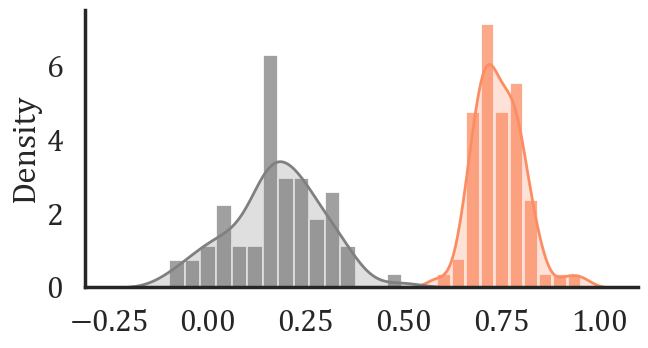

In [5]:
pe_corrs = []
for pe, outcome in zip(
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['fit']['pe']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['rewards'])
):
    r, p = stats.pearsonr(pe, outcome)
    pe_corrs.append(r)

ev_corrs = []
for ev, actions, outcome in zip(
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['fit']['ev']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['choices']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['rewards'])
):
    ev = ev[:-1, :]
    chosen_ev = ev[np.arange(len(actions)), actions.astype(int)]
    # chosen_ev = ev[:, 1]
    r, p = stats.pearsonr(chosen_ev, outcome)
    ev_corrs.append(r)

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# sns.histplot(pe_corrs, ax=ax[0], bins=10, stat='density', color='gray')
# sns.kdeplot(pe_corrs, ax=ax[0], fill=True, color='gray')
# sns.histplot(ev_corrs, ax=ax[1], bins=10, stat='density', color='gray')
# sns.kdeplot(ev_corrs, ax=ax[1], fill=True, color='gray')
# ax[0].set_title('PE Correlations')
# ax[1].set_title('EV Correlations')
# # annotate with significant difference from 0 
# print(stats.ttest_1samp(pe_corrs, 0))
# print(stats.ttest_1samp(ev_corrs, 0))
# sns.despine()
# plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.histplot(pe_corrs, ax=ax, bins=10, stat='density', color=sns.palettes.color_palette('Set2')[1])
sns.kdeplot(pe_corrs, ax=ax, fill=True, color=sns.palettes.color_palette('Set2')[1])
sns.histplot(ev_corrs, ax=ax, bins=15, stat='density', color='gray')
sns.kdeplot(ev_corrs, ax=ax, fill=True, color='gray')
# annotate with significant difference from 0 
print(stats.ttest_1samp(pe_corrs, 0))
print(np.mean(pe_corrs), np.std(pe_corrs))
print(stats.ttest_1samp(ev_corrs, 0))
print(np.mean(ev_corrs), np.std(ev_corrs))
sns.despine()
plt.tight_layout()
# plt.savefig(f'{figure_dir}/supp/pe_ev_outcome_correlations_1.svg', format='svg', dpi=300, transparent=True)

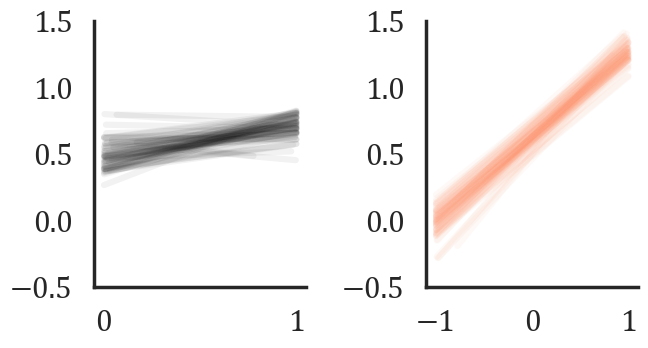

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), sharey=False)
pe_corrs = []
for pe, outcome in zip(
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['fit']['pe']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['rewards'])
):
    sns.regplot(x=pe, y=outcome, ax=ax[1], scatter_kws={'alpha': 0, 'color': sns.palettes.color_palette('Set2')[1]}, line_kws={'color': sns.palettes.color_palette('Set2')[1], 'alpha': 0.05}, ci=None)

ev_corrs = []
for ev, actions, outcome in zip(
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['fit']['ev']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['choices']),
    np.squeeze(decision_modout['alcohol']['d_lrbias_rw_other']['behavior']['rewards'])
):
    ev = ev[:-1, :]
    chosen_ev = ev[np.arange(len(actions)), actions.astype(int)]
    # chosen_ev = ev[:, 1]
    sns.regplot(x=chosen_ev, y=outcome, ax=ax[0], scatter_kws={'alpha': 0, 'color': 'black'}, line_kws={'color': 'black', 'alpha': 0.05}, ci=None)

ax[0].set_ylim(-0.5, 1.5)
ax[1].set_ylim(-0.5, 1.5)
sns.despine()
plt.tight_layout()
# plt.savefig(f'{figure_dir}/supp/pe_ev_outcome_correlations_2.svg', format='svg', dpi=300, transparent=True)

## Addictive cue modeling
LRBias decision model

In [8]:
fitted_craving_modout = {}
fitted_craving_modout['alcohol'] = {}
fitted_craving_modout['cannabis'] = {}

chosen_model = 'd_lrbias_rw'
block = 'other'

if os.path.exists(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['alcohol'] = pickle.load(f)
if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['cannabis'] = pickle.load(f)

Loading existing craving models
Loading existing craving models


In [9]:
def to_include(crav_ratings):
    temp_updated = [val for val in crav_ratings[0] if val != -1]
    temp_updated = np.array(temp_updated)
    vals,counts = np.unique(temp_updated, return_counts=True)
    index = np.argmax(counts)
    most_common = vals[index]
    # count number of times the most common value does not appear in the list
    if len(temp_updated) - np.sum(temp_updated == most_common) < 2:
        return False
    else:
        return True

In [10]:
# Fit/load data for addictive cue condition
save_flag = False
to_include_flag = False

for group in ['alcohol', 'cannabis']:
    craving_modout = {}
    all_data = []
    for craving_ratings, actions, outcomes, evs, rpes in zip(
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['craving_ratings'],
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['choices'],
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['rewards'],
        decision_modout[group][f'{chosen_model}_{block}']['fit']['ev'],
        decision_modout[group][f'{chosen_model}_{block}']['fit']['pe']
    ):
        if to_include_flag:
            if to_include(craving_ratings):
                all_data += [[craving_ratings, actions, outcomes, evs, rpes]]
        else:
            all_data += [[craving_ratings, actions, outcomes, evs, rpes]]

    for model_name, param_names, fit_func in [
        # (f'a_outcome_geodecay_{block}', ['craving_baseline', 'outcome_weight'], craving_models.geodecay_fixed_gamma.a_outcome_geodecay.fit),
        (f'b_ev_geodecay_{block}', ['craving_baseline', 'ev_weight'], craving_models.geodecay_fixed_gamma.b_ev_geodecay.fit),
        (f'c_rpe_geodecay_{block}', ['craving_baseline', 'rpe_weight'], craving_models.geodecay_fixed_gamma.c_rpe_geodecay.fit),
        (f'f_ev_rpe_geodecay_{block}', ['craving_baseline', 'ev_weight', 'rpe_weight'], craving_models.geodecay_fixed_gamma.f_ev_rpe_geodecay.fit),
    ]:
        if model_name in fitted_craving_modout[group]:
            print(f'{model_name} already fit')
            continue

        print(f'Fitting {group} - {model_name} - {block.capitalize()} block')
        m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, fit_func, param_names)
        craving_modout = store_craving_modout(
            craving_modout, model_name, param_names, all_data, fit_func, 
            m, inv_h, posterior, NPL, NLPrior, NLL
        )
        fitted_craving_modout[group] = craving_modout
    if save_flag:
        with open(f'{craving_results_dir}/{group}_{chosen_model}_{block}_craving_models.pkl', 'wb') as f:
            pickle.dump(fitted_craving_modout[group], f)

b_ev_geodecay_other already fit
c_rpe_geodecay_other already fit
f_ev_rpe_geodecay_other already fit
b_ev_geodecay_other already fit
c_rpe_geodecay_other already fit
f_ev_rpe_geodecay_other already fit


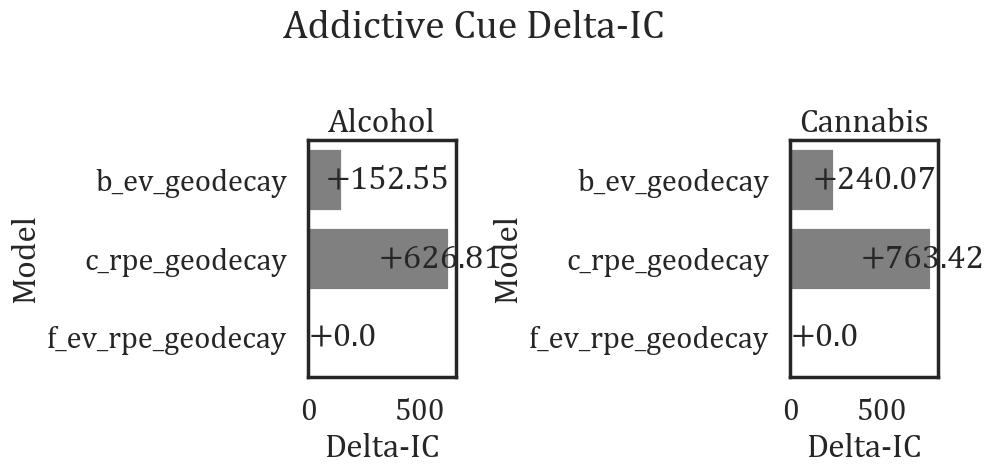

In [11]:
model_comparison_by_group(fitted_craving_modout, 'other')

In [12]:
fig_alcohol, fig_cannabis, full_df = craving_model_comparison_by_group_for_paper(fitted_craving_modout, 'other', figsize=(35*mm, 21*mm))
full_df

,Model,Type,IC,Group,Delta-IC
0,b_ev_geodecay,Other,12826.837001,alcohol,152.553595
1,c_rpe_geodecay,Other,13301.090166,alcohol,626.806759
2,f_ev_rpe_geodecay,Other,12674.283407,alcohol,0.000000
3,b_ev_geodecay,Other,13662.118335,cannabis,240.071988
4,c_rpe_geodecay,Other,14185.468953,cannabis,763.422606
5,f_ev_rpe_geodecay,Other,13422.046347,cannabis,0.000000


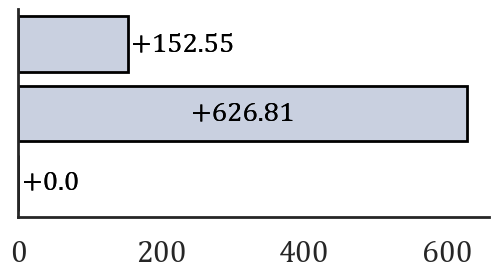

In [13]:
# fig_alcohol.savefig(f'{figure_dir}/fig3_alcohol_craving_models_other.svg', format='svg', dpi=300, transparent=True)
fig_alcohol

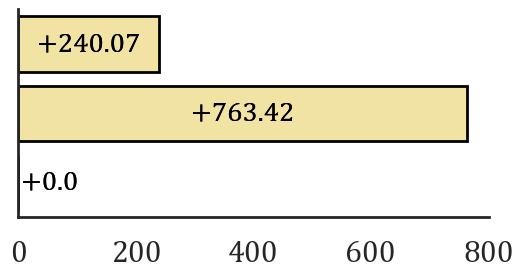

In [14]:
# fig_cannabis.savefig(f'{figure_dir}/fig3_cannabis_craving_models_other.svg', format='svg', dpi=300, transparent=True)
fig_cannabis

In [15]:
model_ordering = {
    'b_ev_geodecay': 0,
    'c_rpe_geodecay': 1,
    'f_ev_rpe_geodecay': 2
}

In [16]:
full_other_bics = pd.DataFrame()
condition = 'other'
ic_type = 'bic'

for group, modout in fitted_craving_modout.items():
    group_bics = pd.DataFrame()
    for model_name, model in modout.items():
        if condition in model_name:
            best_fit = model['fit'][ic_type][:, 0]
            # Replace nan with mean value
            best_fit[np.isnan(best_fit)] = np.nanmean(best_fit)
            summed_ic = np.sum(best_fit)
            
            model_df = pd.DataFrame({
                'Model': [model_name[:-6]],
                'Type': [condition.capitalize()],
                'IC': [summed_ic],
                'Group': [group],
                'Model Order': [model_ordering[model_name[:-6]]]
            })
            group_bics = pd.concat([group_bics, model_df], ignore_index=True)
    group_bics['Delta-IC'] = group_bics['IC'] - group_bics['IC'].min()
    full_other_bics = pd.concat([full_other_bics, group_bics], ignore_index=True)

full_other_bics

,Model,Type,IC,Group,Model Order,Delta-IC
0,b_ev_geodecay,Other,12826.837001,alcohol,0,152.553595
1,c_rpe_geodecay,Other,13301.090166,alcohol,1,626.806759
2,f_ev_rpe_geodecay,Other,12674.283407,alcohol,2,0.000000
3,b_ev_geodecay,Other,13662.118335,cannabis,0,240.071988
4,c_rpe_geodecay,Other,14185.468953,cannabis,1,763.422606
5,f_ev_rpe_geodecay,Other,13422.046347,cannabis,2,0.000000


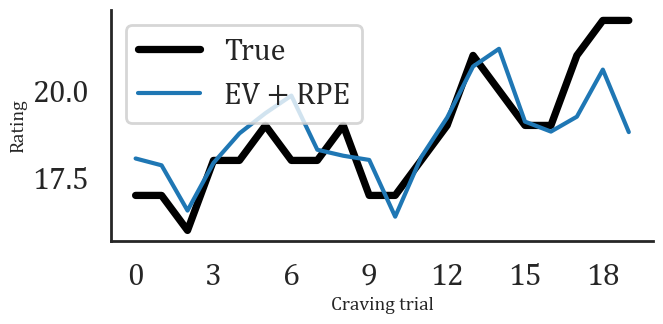

In [18]:
sub_idx = 26
block = 'other'

label_dict = {
    'b_ev_geodecay': 'EV only',
    'c_rpe_geodecay': 'RPE only',
    'f_ev_rpe_geodecay': 'EV + RPE',
}

true_cravings = fitted_craving_modout['alcohol'][f'f_ev_rpe_geodecay_other']['fit']['craving_ratings'][sub_idx, 0]
# Extract ratings that are greater than 1
true_cravings = true_cravings[true_cravings > -1]

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
sns.lineplot(data=pd.Series(true_cravings), ax=ax, label='True', color='black', linewidth=5.25)

for model_name in fitted_craving_modout['alcohol']:
    if 'ev_rpe_geodecay' not in model_name:
        continue
    if block not in model_name:
        continue
    pred_cravings = fitted_craving_modout['alcohol'][model_name]['fit']['pred_cravings'][sub_idx, 0]
    pred_cravings = pred_cravings[pred_cravings > -1]

    label = label_dict[model_name[:-6]]
    sns.lineplot(data=pd.Series(pred_cravings), ax=ax, label=f'{label}', linewidth=3)
    # ax.set_title(f'{model_name} - {block.capitalize()} block - Subject {sub_idx}')
    ax.set_xlabel('Craving trial', fontsize=14)
    ax.set_ylabel('Rating', fontsize=14)
    # set x-axis ticks as integers
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax.set_xticks([])

plt.setp(ax.spines.values(), linewidth=2)
sns.despine()

#save fig as svg
# plt.savefig(f'{figure_dir}/supp/alcohol_money_predicted_craving_evrpe.svg', format='svg', dpi=300, transparent=True)

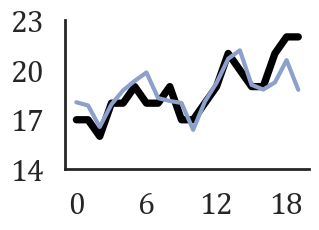

In [19]:
sub_idx = 26
block = 'other'

label_dict = {
    'b_ev_geodecay': 'EV only',
    'c_rpe_geodecay': 'RPE only',
    'f_ev_rpe_geodecay': 'EV + RPE',
}

true_cravings = fitted_craving_modout['alcohol'][f'f_ev_rpe_geodecay_other']['fit']['craving_ratings'][sub_idx, 0]
# Extract ratings that are greater than 1
true_cravings = true_cravings[true_cravings > -1]

# mm = 1/25.4*2
fig, ax = plt.subplots(1, 1, figsize=(20*mm, 12.3*mm))
sns.lineplot(data=pd.Series(true_cravings), ax=ax, label='True', color='black', linewidth=5.25, legend=False)

for model_name in fitted_craving_modout['alcohol']:
    if 'ev_rpe_geodecay' not in model_name:
        continue
    if block not in model_name:
        continue
    pred_cravings = fitted_craving_modout['alcohol'][model_name]['fit']['pred_cravings'][sub_idx, 0]
    pred_cravings = pred_cravings[pred_cravings > -1]

    label = label_dict[model_name[:-6]]
    sns.lineplot(data=pd.Series(pred_cravings), ax=ax, label=f'{label}', linewidth=3, legend=False, color=sns.palettes.color_palette("Set2")[2])
    # ax.set_title(f'{model_name} - {block.capitalize()} block - Subject {sub_idx}')
    # ax.set_xlabel('Craving trial', fontsize=14)
    # ax.set_ylabel('Rating', fontsize=14)
    # set x-axis ticks as integers
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xticks([0, 6, 12, 18])
    ax.set_yticks([14, 17, 20, 23])

plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel('')
sns.despine()

#save fig as svg
# plt.savefig(f'{figure_dir}/fig3_alcohol_other_predicted_craving_evrpe.svg', format='svg', dpi=300, transparent=True)

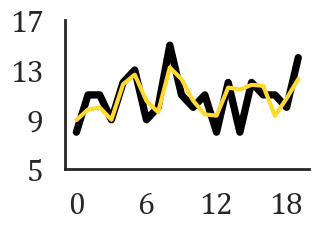

In [20]:
sub_idx = 8
block = 'other'

label_dict = {
    'b_ev_geodecay': 'EV only',
    'c_rpe_geodecay': 'RPE only',
    'f_ev_rpe_geodecay': 'EV + RPE',
}

true_cravings = fitted_craving_modout['cannabis'][f'f_ev_rpe_geodecay_other']['fit']['craving_ratings'][sub_idx, 0]
# Extract ratings that are greater than 1
true_cravings = true_cravings[true_cravings > -1]

# mm = 1/25.4*2
fig, ax = plt.subplots(1, 1, figsize=(20*mm, 12.3*mm))
sns.lineplot(data=pd.Series(true_cravings), ax=ax, label='True', color='black', linewidth=5.25, legend=False)

for model_name in fitted_craving_modout['cannabis']:
    if 'ev_rpe_geodecay' not in model_name:
        continue
    if block not in model_name:
        continue
    pred_cravings = fitted_craving_modout['cannabis'][model_name]['fit']['pred_cravings'][sub_idx, 0]
    pred_cravings = pred_cravings[pred_cravings > -1]

    label = label_dict[model_name[:-6]]
    sns.lineplot(data=pd.Series(pred_cravings), ax=ax, label=f'{label}', linewidth=3, legend=False, color=sns.palettes.color_palette("Set2")[5])
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xticks([0, 6, 12, 18])
    ax.set_yticks([5, 9, 13, 17])

plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel('')
sns.despine()

#save fig as svg
# plt.savefig(f'{figure_dir}/fig3_cannabis_other_predicted_craving_evrpe.svg', format='svg', dpi=300, transparent=True)

In [21]:
model_names = []
corrs = []
groups = []
sq_errs = []

for group in ['alcohol', 'cannabis']:
    craving_modout = fitted_craving_modout[group]
    for model_name in craving_modout:
        true_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['craving_ratings'])
        pred_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['pred_cravings'])
        for i, (t, p) in enumerate(zip(true_cravings, pred_cravings)):
            true_cravings = t[t > -1]
            pred_cravings = p[p > -1]
            if len(true_cravings) != len(pred_cravings):
                print(f'Lengths do not match for Subj: {i}, {model_name} - {block.capitalize()} block')
                continue

            corrs.append(stats.pearsonr(true_cravings, pred_cravings)[0])
            sq_errs.append(np.mean((true_cravings - pred_cravings)**2))
            model_names.append("_".join(model_name.split('_')[:-1]))
            groups.append(group)

corr_df = pd.DataFrame({
    'Model': model_names,
    'Group': groups,
    'Corr': corrs,
    'Sq_Err': sq_errs
})
corr_df

,Model,Group,Corr,Sq_Err
0,b_ev_geodecay,alcohol,0.018462,3.446382
1,b_ev_geodecay,alcohol,0.655005,1.340353
2,b_ev_geodecay,alcohol,0.136489,8.880396
3,b_ev_geodecay,alcohol,0.857644,5.037145
4,b_ev_geodecay,alcohol,0.565325,2.799125
...,...,...,...,...
394,f_ev_rpe_geodecay,cannabis,0.425646,19.361949
395,f_ev_rpe_geodecay,cannabis,0.626849,4.860818
396,f_ev_rpe_geodecay,cannabis,0.773926,19.967000
397,f_ev_rpe_geodecay,cannabis,0.482657,1.311672


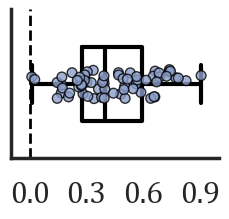

In [22]:
alc_corr_df = corr_df[(corr_df['Group'] == 'alcohol')&(corr_df['Model']=='f_ev_rpe_geodecay')]
can_corr_df = corr_df[(corr_df['Group'] == 'cannabis')&(corr_df['Model']=='f_ev_rpe_geodecay')]

fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
# sns.stripplot(data=alc_corr_df, x='Model', y='Corr', hue='Group', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, legend=False)
sns.boxplot(data=alc_corr_df, hue='Model', x='Corr', palette=['black'], legend=False, width=0.5, ax=ax, linewidth=3, fill=False, orient='h')
sns.stripplot(data=alc_corr_df, hue='Model', x='Corr', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, ax=ax, legend=False, alpha=0.8, size=7, linewidth=1, edgecolor='black', orient='h')
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_xticks([0.0, 0.3, 0.6, 0.9])
ax.set_xlim([-0.1, 1])
# dotted horizontal line at 0
ax.axvline(0, color='black', linewidth=2, linestyle='--')
# set axis linewidth
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(3)
sns.despine()
# fig.savefig(f'{figure_dir}/fig3_alcohol_other_craving_truepred_corr.svg', format='svg', dpi=300, transparent=True)

,Corr,Sq_Err
count,68.000000,68.000000
mean,0.438535,15.186818
std,0.208124,56.490498
min,0.009465,0.040260
25%,0.273659,1.286717
50%,0.395312,3.740375
75%,0.594668,10.846700
max,0.907184,463.832463


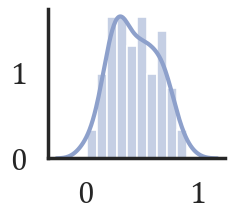

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(14.5*mm, 12.3*mm))
sns.histplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[2]], ax=ax, kde=False, bins=10, legend=False, stat='density')
sns.kdeplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[2]], ax=ax, legend=False)
ax.set_xlabel('')
ax.set_ylabel('')
sns.despine()
# fig.savefig(f'{figure_dir}/fig3_alcohol_other_craving_truepred_corr_hist.svg', format='svg', dpi=300, transparent=True)
#summary stats for alc_corr_df
alc_corr_df.describe()

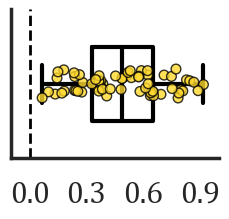

In [24]:
alc_corr_df = corr_df[(corr_df['Group'] == 'cannabis')&(corr_df['Model']=='f_ev_rpe_geodecay')]
fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
# sns.stripplot(data=alc_corr_df, x='Model', y='Corr', hue='Group', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, legend=False)
sns.boxplot(data=alc_corr_df, hue='Model', x='Corr', palette=['black'], legend=False, width=0.5, ax=ax, linewidth=3, fill=False, orient='h')
sns.stripplot(data=alc_corr_df, hue='Model', x='Corr', palette=[sns.palettes.color_palette("Set2")[5]], dodge=True, ax=ax, legend=False, alpha=0.8, size=7, linewidth=1, edgecolor='black', orient='h')
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_xticks([0.0, 0.3, 0.6, 0.9])
ax.set_xlim([-0.1, 1])
# dotted horizontal line at 0
ax.axvline(0, color='black', linewidth=2, linestyle='--')
# set axis linewidth
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(3)
sns.despine()
# fig.savefig(f'{figure_dir}/fig3_cannabis_other_craving_truepred_corr.svg', format='svg', dpi=300, transparent=True)

,Corr,Sq_Err
count,65.000000,65.000000
mean,0.487222,13.808624
std,0.226718,20.395171
min,0.064515,0.041123
25%,0.327325,1.502797
50%,0.487345,4.704217
75%,0.651031,19.190317
max,0.919386,84.717461


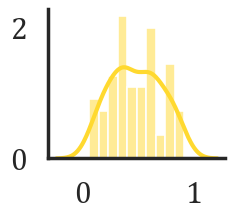

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14.5*mm, 12.3*mm))
sns.histplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[5]], ax=ax, kde=False, bins=10, legend=False, stat='density')
sns.kdeplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[5]], ax=ax, legend=False)
ax.set_xlabel('')
ax.set_ylabel('')
sns.despine()
# fig.savefig(f'{figure_dir}/fig3_cannabis_other_craving_truepred_corr_hist.svg', format='svg', dpi=300, transparent=True)
#summary stats for alc_corr_df
can_corr_df.describe()

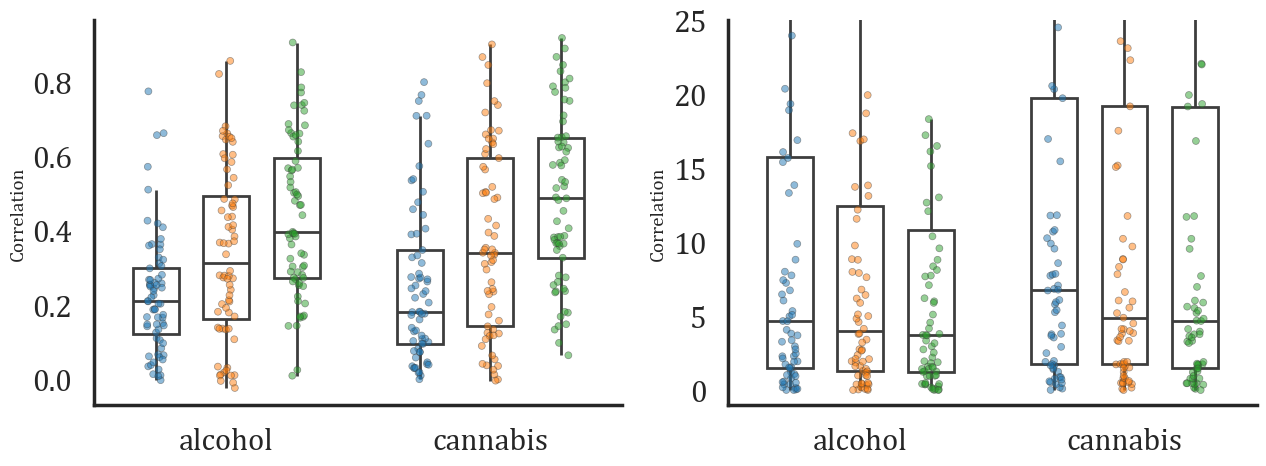

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# myboxplotprops = {
#     'medianprops': dict(linewidth=2),
#     'whiskerprops': dict(linewidth=2),
#     'capprops': dict(linewidth=0),
#     'boxprops': dict(fill=0, linewidth=2),
#     'fliersize': 0,
#     'gap': 0.2,
#     'legend': False
# }
# mystripplotprops = {
#     'alpha': 1,
#     'dodge': True,
#     'legend': False,
#     'size': 10,
#     'linewidth': 1
# }

#no outliers, spacing between boxes
sns.stripplot(x='Group', y='Corr', hue='Model', data=corr_df, ax=ax[0], hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'], **mystripplotprops)
sns.boxplot(x='Group', y='Corr', hue='Model', data=corr_df, ax=ax[0], hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'], **myboxplotprops)
# ax[0].set_title('Correlation between true and predicted craving ratings')
# set x-axis ticks as to capitalized groups
# ax[0].set_xticklabels(['Alcohol', 'Cannabis'], fontsize=14)
# set x-axis label
ax[0].set_xlabel('')
# set y-axis label
ax[0].set_ylabel('Correlation', fontsize=14)

sns.stripplot(x='Group', y='Sq_Err', hue='Model', data=corr_df, ax=ax[1], hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'], **mystripplotprops)
sns.boxplot(x='Group', y='Sq_Err', hue='Model', data=corr_df, ax=ax[1], hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'], **myboxplotprops)
# ax[1].set_title('Mean Squared Error between true and predicted craving ratings')
ax[1].set_ylim(-1, 25)
# ax[1].set_xticklabels(['Alcohol', 'Cannabis'], fontsize=14)
# set x-axis label
ax[1].set_xlabel('')
# set y-axis label
ax[1].set_ylabel('Correlation', fontsize=14)

sns.despine()

#save fig as svg
# plt.savefig(f'/Users/kulkarnik/LocalProjects/SlotsTasks_simplified_rhoads/outputs/figures/money_craving_pred_metrics.svg', format='svg', dpi=300, transparent=True)

## Money cue modeling
RewBias decision model

In [28]:
fitted_craving_modout = {}
fitted_craving_modout['alcohol'] = {}
fitted_craving_modout['cannabis'] = {}

chosen_model = 'o_add_rewbias_rw'
block = 'money'

save_fit_path=f'{results_dir}/craving/'
if not os.path.exists(save_fit_path):
    os.makedirs(save_fit_path)
if os.path.exists(f'{save_fit_path}/alcohol_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{save_fit_path}/alcohol_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['alcohol'] = pickle.load(f)
if os.path.exists(f'{save_fit_path}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{save_fit_path}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['cannabis'] = pickle.load(f)

Loading existing craving models
Loading existing craving models


In [29]:
# Fit/load data for money cue condition
save_flag = False
to_include_flag = False

for group in ['alcohol', 'cannabis']:
    craving_modout = {}
    all_data = []
    for craving_ratings, actions, outcomes, evs, rpes in zip(
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['craving_ratings'],
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['choices'],
        decision_modout[group][f'{chosen_model}_{block}']['behavior']['rewards'],
        decision_modout[group][f'{chosen_model}_{block}']['fit']['ev'],
        decision_modout[group][f'{chosen_model}_{block}']['fit']['pe']
    ):
        if to_include_flag:
            if to_include(craving_ratings):
                all_data += [[craving_ratings, actions, outcomes, evs, rpes]]
        else:
            all_data += [[craving_ratings, actions, outcomes, evs, rpes]]

    for model_name, param_names, fit_func in [
        (f'b_ev_geodecay_{block}', ['craving_baseline', 'ev_weight'], craving_models.geodecay_fixed_gamma.b_ev_geodecay.fit),
        (f'c_rpe_geodecay_{block}', ['craving_baseline', 'rpe_weight'], craving_models.geodecay_fixed_gamma.c_rpe_geodecay.fit),
        (f'f_ev_rpe_geodecay_{block}', ['craving_baseline', 'ev_weight', 'rpe_weight'], craving_models.geodecay_fixed_gamma.f_ev_rpe_geodecay.fit),
    ]:
        if model_name in fitted_craving_modout[group]:
            print(f'{model_name} already fit')
            continue

        print(f'Fitting {group} - {model_name} - {block.capitalize()} block')
        m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, fit_func, param_names)
        craving_modout = store_craving_modout(
            craving_modout, model_name, param_names, all_data, fit_func, 
            m, inv_h, posterior, NPL, NLPrior, NLL
        )
        fitted_craving_modout[group] = craving_modout
    if save_flag:
        with open(f'{save_fit_path}/{group}_{chosen_model}_{block}_craving_models.pkl', 'wb') as f:
            pickle.dump(fitted_craving_modout[group], f)

b_ev_geodecay_money already fit
c_rpe_geodecay_money already fit
f_ev_rpe_geodecay_money already fit
b_ev_geodecay_money already fit
c_rpe_geodecay_money already fit
f_ev_rpe_geodecay_money already fit


In [30]:
fig_alcohol, fig_cannabis, full_df = craving_model_comparison_by_group_for_paper(fitted_craving_modout, 'money', figsize=(35*mm, 21*mm))
full_df

,Model,Type,IC,Group,Delta-IC
0,b_ev_geodecay,Money,12653.976214,alcohol,369.331725
1,c_rpe_geodecay,Money,12988.760544,alcohol,704.116056
2,f_ev_rpe_geodecay,Money,12284.644489,alcohol,0.000000
3,b_ev_geodecay,Money,12915.893680,cannabis,133.227923
4,c_rpe_geodecay,Money,13321.457431,cannabis,538.791675
5,f_ev_rpe_geodecay,Money,12782.665757,cannabis,0.000000


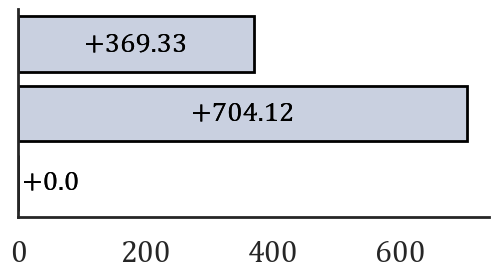

In [31]:
# fig_alcohol.savefig(f'{figure_dir}/supp/supp_fig5_alcohol_craving_models_money.svg', format='svg', dpi=300, transparent=True)
fig_alcohol

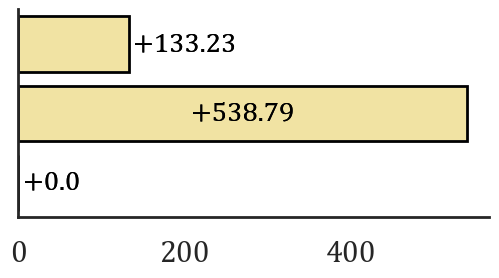

In [32]:
# fig_cannabis.savefig(f'{figure_dir}/supp/supp_fig5_cannabis_craving_models_money.svg', format='svg', dpi=300, transparent=True)
fig_cannabis

In [33]:
model_ordering = {
    'b_ev_geodecay': 0,
    'c_rpe_geodecay': 1,
    'f_ev_rpe_geodecay': 2
}

In [34]:
full_other_bics = pd.DataFrame()
condition = 'money'
ic_type = 'bic'

for group, modout in fitted_craving_modout.items():
    group_bics = pd.DataFrame()
    for model_name, model in modout.items():
        if condition in model_name:
            best_fit = model['fit'][ic_type][:, 0]
            # Replace nan with mean value
            best_fit[np.isnan(best_fit)] = np.nanmean(best_fit)
            summed_ic = np.sum(best_fit)
            
            model_df = pd.DataFrame({
                'Model': [model_name[:-6]],
                'Type': [condition.capitalize()],
                'IC': [summed_ic],
                'Group': [group],
                'Model Order': [model_ordering[model_name[:-6]]]
            })
            group_bics = pd.concat([group_bics, model_df], ignore_index=True)
    group_bics['Delta-IC'] = group_bics['IC'] - group_bics['IC'].min()
    full_other_bics = pd.concat([full_other_bics, group_bics], ignore_index=True)

full_other_bics

,Model,Type,IC,Group,Model Order,Delta-IC
0,b_ev_geodecay,Money,12653.976214,alcohol,0,369.331725
1,c_rpe_geodecay,Money,12988.760544,alcohol,1,704.116056
2,f_ev_rpe_geodecay,Money,12284.644489,alcohol,2,0.000000
3,b_ev_geodecay,Money,12915.893680,cannabis,0,133.227923
4,c_rpe_geodecay,Money,13321.457431,cannabis,1,538.791675
5,f_ev_rpe_geodecay,Money,12782.665757,cannabis,2,0.000000


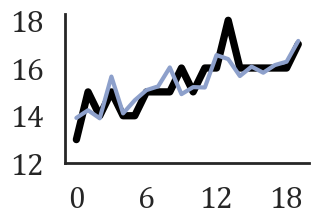

In [35]:
sub_idx = 26
block = 'money'

label_dict = {
    'b_ev_geodecay': 'EV only',
    'c_rpe_geodecay': 'RPE only',
    'f_ev_rpe_geodecay': 'EV + RPE',
}

true_cravings = fitted_craving_modout['alcohol'][f'f_ev_rpe_geodecay_money']['fit']['craving_ratings'][sub_idx, 0]
# Extract ratings that are greater than 1
true_cravings = true_cravings[true_cravings > -1]

# mm = 1/25.4*2
fig, ax = plt.subplots(1, 1, figsize=(20*mm, 12.3*mm))
sns.lineplot(data=pd.Series(true_cravings), ax=ax, label='True', color='black', linewidth=5.25, legend=False)

for model_name in fitted_craving_modout['alcohol']:
    if 'ev_rpe_geodecay' not in model_name:
        continue
    if block not in model_name:
        continue
    pred_cravings = fitted_craving_modout['alcohol'][model_name]['fit']['pred_cravings'][sub_idx, 0]
    pred_cravings = pred_cravings[pred_cravings > -1]

    label = label_dict[model_name[:-6]]
    sns.lineplot(data=pd.Series(pred_cravings), ax=ax, label=f'{label}', linewidth=3, legend=False, color=sns.palettes.color_palette("Set2")[2])
    # ax.set_title(f'{model_name} - {block.capitalize()} block - Subject {sub_idx}')
    # ax.set_xlabel('Craving trial', fontsize=14)
    # ax.set_ylabel('Rating', fontsize=14)
    # set x-axis ticks as integers
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xticks([0, 6, 12, 18])
    ax.set_yticks([12, 14, 16, 18])

plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel('')
sns.despine()

#save fig as svg
# plt.savefig(f'{figure_dir}/supp/supp_fig5_alcohol_money_predicted_craving_evrpe.svg', format='svg', dpi=300, transparent=True)

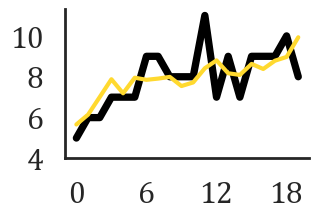

In [36]:
sub_idx = 8
block = 'money'

label_dict = {
    'b_ev_geodecay': 'EV only',
    'c_rpe_geodecay': 'RPE only',
    'f_ev_rpe_geodecay': 'EV + RPE',
}

true_cravings = fitted_craving_modout['cannabis'][f'f_ev_rpe_geodecay_money']['fit']['craving_ratings'][sub_idx, 0]
# Extract ratings that are greater than 1
true_cravings = true_cravings[true_cravings > -1]

# mm = 1/25.4*2
fig, ax = plt.subplots(1, 1, figsize=(20*mm, 12.3*mm))
sns.lineplot(data=pd.Series(true_cravings), ax=ax, label='True', color='black', linewidth=5.25, legend=False)

for model_name in fitted_craving_modout['cannabis']:
    if 'ev_rpe_geodecay' not in model_name:
        continue
    if block not in model_name:
        continue
    pred_cravings = fitted_craving_modout['cannabis'][model_name]['fit']['pred_cravings'][sub_idx, 0]
    pred_cravings = pred_cravings[pred_cravings > -1]

    label = label_dict[model_name[:-6]]
    sns.lineplot(data=pd.Series(pred_cravings), ax=ax, label=f'{label}', linewidth=3, legend=False, color=sns.palettes.color_palette("Set2")[5])
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xticks([0, 6, 12, 18])
    ax.set_yticks([4, 6, 8, 10])

plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel('')
sns.despine()

#save fig as svg
# plt.savefig(f'{figure_dir}/supp/supp_fig5_cannabis_money_predicted_craving_evrpe.svg', format='svg', dpi=300, transparent=True)

In [37]:
model_names = []
corrs = []
groups = []
sq_errs = []

for group in ['alcohol', 'cannabis']:
    craving_modout = fitted_craving_modout[group]
    for model_name in craving_modout:
        true_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['craving_ratings'])
        pred_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['pred_cravings'])
        for i, (t, p) in enumerate(zip(true_cravings, pred_cravings)):
            true_cravings = t[t > -1]
            pred_cravings = p[p > -1]
            if len(true_cravings) != len(pred_cravings):
                print(f'Lengths do not match for Subj: {i}, {model_name} - {block.capitalize()} block')
                continue

            corrs.append(stats.pearsonr(true_cravings, pred_cravings)[0])
            sq_errs.append(np.mean((true_cravings - pred_cravings)**2))
            model_names.append("_".join(model_name.split('_')[:-1]))
            groups.append(group)

corr_df = pd.DataFrame({
    'Model': model_names,
    'Group': groups,
    'Corr': corrs,
    'Sq_Err': sq_errs
})
corr_df

Lengths do not match for Subj: 38, c_rpe_geodecay_money - Money block
Lengths do not match for Subj: 22, f_ev_rpe_geodecay_money - Money block


,Model,Group,Corr,Sq_Err
0,b_ev_geodecay,alcohol,0.224968,0.987381
1,b_ev_geodecay,alcohol,0.821787,10.637211
2,b_ev_geodecay,alcohol,0.676520,1.632396
3,b_ev_geodecay,alcohol,0.628978,3.113620
4,b_ev_geodecay,alcohol,0.651489,2.064918
...,...,...,...,...
392,f_ev_rpe_geodecay,cannabis,0.045503,0.147195
393,f_ev_rpe_geodecay,cannabis,0.340400,2.588690
394,f_ev_rpe_geodecay,cannabis,0.294489,50.836010
395,f_ev_rpe_geodecay,cannabis,0.532416,4.124005


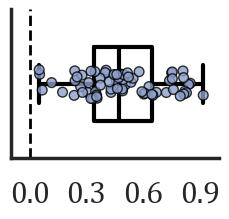

In [38]:
alc_corr_df = corr_df[(corr_df['Group'] == 'alcohol')&(corr_df['Model']=='f_ev_rpe_geodecay')]
fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
# sns.stripplot(data=alc_corr_df, x='Model', y='Corr', hue='Group', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, legend=False)
sns.boxplot(data=alc_corr_df, hue='Model', x='Corr', palette=['black'], legend=False, width=0.5, ax=ax, linewidth=3, fill=False, orient='h')
sns.stripplot(data=alc_corr_df, hue='Model', x='Corr', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, ax=ax, legend=False, alpha=0.8, size=7, linewidth=1, edgecolor='black', orient='h')
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_xticks([0.0, 0.3, 0.6, 0.9])
ax.set_xlim([-0.1, 1])
# dotted horizontal line at 0
ax.axvline(0, color='black', linewidth=2, linestyle='--')
# set axis linewidth
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(3)
sns.despine()
# fig.savefig(f'{figure_dir}/supp/supp_fig5_alcohol_money_craving_truepred_corr.svg', format='svg', dpi=300, transparent=True)

,Corr,Sq_Err
count,67.000000,67.000000
mean,0.488830,19.419799
std,0.217629,69.141592
min,0.048631,0.047388
25%,0.338451,0.970618
50%,0.470179,2.583923
75%,0.648967,8.848382
max,0.918371,515.077221


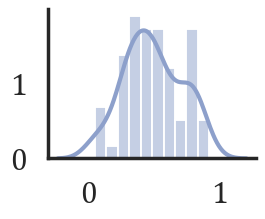

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
sns.histplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[2]], ax=ax, kde=False, bins=10, legend=False, stat='density')
sns.kdeplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[2]], ax=ax, legend=False)
ax.set_xlabel('')
ax.set_ylabel('')
sns.despine()
# fig.savefig(f'{figure_dir}/supp/supp_fig5_alcohol_money_craving_truepred_corr_hist.svg', format='svg', dpi=300, transparent=True)
#summary stats for alc_corr_df
alc_corr_df.describe()

,Corr,Sq_Err
count,65.000000,65.000000
mean,0.446210,13.076696
std,0.210694,21.777253
min,0.043358,0.147195
25%,0.301380,1.225062
50%,0.398084,3.430742
75%,0.619697,13.806610
max,0.886069,105.661101


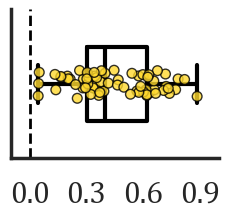

In [40]:
can_corr_df = corr_df[(corr_df['Group'] == 'cannabis')&(corr_df['Model']=='f_ev_rpe_geodecay')]
fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
# sns.stripplot(data=can_corr_df, x='Model', y='Corr', hue='Group', palette=[sns.palettes.color_palette("Set2")[2]], dodge=True, legend=False)
sns.boxplot(data=can_corr_df, hue='Model', x='Corr', palette=['black'], legend=False, width=0.5, ax=ax, linewidth=3, fill=False, orient='h')
sns.stripplot(data=can_corr_df, hue='Model', x='Corr', palette=[sns.palettes.color_palette("Set2")[5]], dodge=True, ax=ax, legend=False, alpha=0.8, size=7, linewidth=1, edgecolor='black', orient='h')
ax.set_xlabel('')
ax.set_ylabel('', fontsize=14)
ax.set_xticks([0.0, 0.3, 0.6, 0.9])
ax.set_xlim([-0.1, 1])
# dotted horizontal line at 0
ax.axvline(0, color='black', linewidth=2, linestyle='--')
# set axis linewidth
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(3)
sns.despine()
# fig.savefig(f'{figure_dir}/supp/supp_fig5_cannabis_money_craving_truepred_corr.svg', format='svg', dpi=300, transparent=True)
#summary stats for alc_corr_df
can_corr_df.describe()

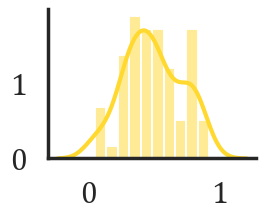

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(17*mm, 12.3*mm))
sns.histplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[5]], ax=ax, kde=False, bins=10, legend=False, stat='density')
sns.kdeplot(data=alc_corr_df, x='Corr', hue='Model', palette=[sns.palettes.color_palette("Set2")[5]], ax=ax, legend=False)
ax.set_xlabel('')
ax.set_ylabel('')
sns.despine()
# fig.savefig(f'{figure_dir}/supp/supp_fig5_cannabis_money_craving_truepred_corr_hist.svg', format='svg', dpi=300, transparent=True)

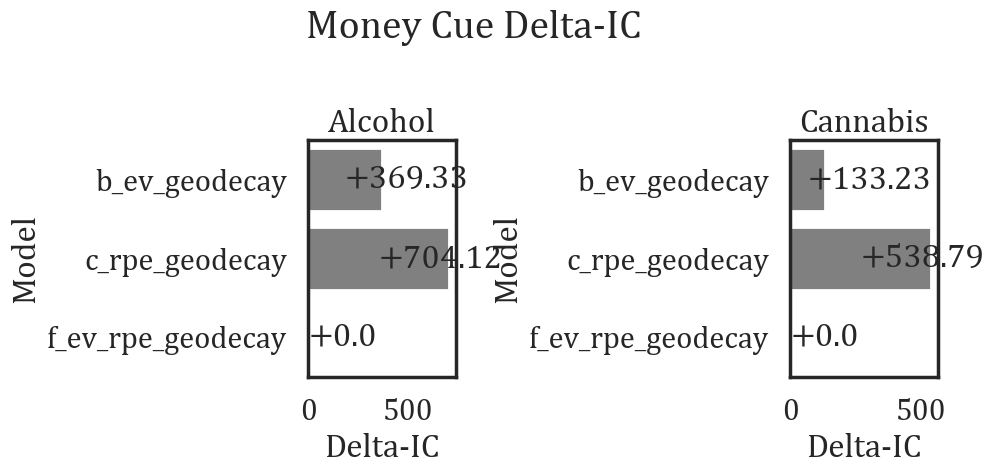

In [42]:
model_comparison_by_group(fitted_craving_modout, 'money')

In [44]:
model_ordering = {
    'b_ev_geodecay': 0,
    'c_rpe_geodecay': 1,
    'f_ev_rpe_geodecay': 2
}

In [45]:
full_money_bics = pd.DataFrame()
condition = 'money'
ic_type = 'bic'

for group, modout in fitted_craving_modout.items():
    group_bics = pd.DataFrame()
    for model_name, model in modout.items():
        if condition in model_name:
            best_fit = model['fit'][ic_type][:, 0]
            # Replace nan with mean value
            best_fit[np.isnan(best_fit)] = np.nanmean(best_fit)
            summed_ic = np.sum(best_fit)
            
            model_df = pd.DataFrame({
                'Model': [model_name[:-6]],
                'Type': [condition.capitalize()],
                'IC': [summed_ic],
                'Group': [group],
                'Model Order': [model_ordering[model_name[:-6]]]
            })
            group_bics = pd.concat([group_bics, model_df], ignore_index=True)
    group_bics['Delta-IC'] = group_bics['IC'] - group_bics['IC'].min()
    full_money_bics = pd.concat([full_money_bics, group_bics], ignore_index=True)

full_money_bics

,Model,Type,IC,Group,Model Order,Delta-IC
0,b_ev_geodecay,Money,12653.976214,alcohol,0,369.331725
1,c_rpe_geodecay,Money,12988.760544,alcohol,1,704.116056
2,f_ev_rpe_geodecay,Money,12284.644489,alcohol,2,0.000000
3,b_ev_geodecay,Money,12915.893680,cannabis,0,133.227923
4,c_rpe_geodecay,Money,13321.457431,cannabis,1,538.791675
5,f_ev_rpe_geodecay,Money,12782.665757,cannabis,2,0.000000


In [47]:
model_names = []
corrs = []
groups = []
sq_errs = []

for group in ['alcohol', 'cannabis']:
    craving_modout = fitted_craving_modout[group]
    for model_name in craving_modout:
        true_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['craving_ratings'])
        pred_cravings = np.squeeze(craving_modout[f'{model_name}']['fit']['pred_cravings'])
        for i, (t, p) in enumerate(zip(true_cravings, pred_cravings)):
            true_cravings = t[t > -1]
            pred_cravings = p[p > -1]
            if len(true_cravings) != len(pred_cravings):
                print(f'Lengths do not match for Subj: {i}, {model_name} - {block.capitalize()} block')
                continue

            corrs.append(stats.pearsonr(true_cravings, pred_cravings)[0])
            sq_errs.append(np.mean((true_cravings - pred_cravings)**2))
            model_names.append("_".join(model_name.split('_')[:-1]))
            groups.append(group)

corr_df = pd.DataFrame({
    'Model': model_names,
    'Group': groups,
    'Corr': corrs,
    'Sq_Err': sq_errs
})
corr_df

Lengths do not match for Subj: 38, c_rpe_geodecay_money - Money block
Lengths do not match for Subj: 22, f_ev_rpe_geodecay_money - Money block


,Model,Group,Corr,Sq_Err
0,b_ev_geodecay,alcohol,0.224968,0.987381
1,b_ev_geodecay,alcohol,0.821787,10.637211
2,b_ev_geodecay,alcohol,0.676520,1.632396
3,b_ev_geodecay,alcohol,0.628978,3.113620
4,b_ev_geodecay,alcohol,0.651489,2.064918
...,...,...,...,...
392,f_ev_rpe_geodecay,cannabis,0.045503,0.147195
393,f_ev_rpe_geodecay,cannabis,0.340400,2.588690
394,f_ev_rpe_geodecay,cannabis,0.294489,50.836010
395,f_ev_rpe_geodecay,cannabis,0.532416,4.124005


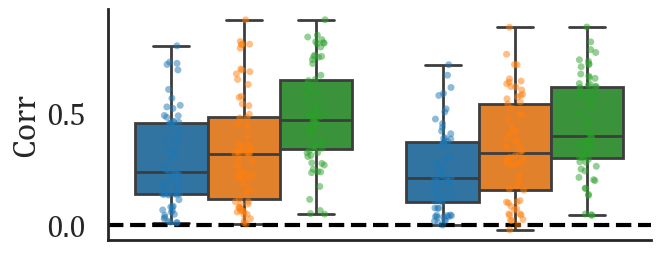

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

bp = sns.boxplot(
    x='Group', y='Corr', hue='Model', data=corr_df, ax=ax, showfliers=False,
    boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), medianprops=dict(linewidth=2), meanprops=dict(linewidth=2),
    hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'],
    # palette='Set2'
)
sns.stripplot(
    x='Group', y='Corr', hue='Model', data=corr_df, ax=ax, dodge=True, 
    alpha=.5,legend=False, 
    hue_order=['c_rpe_geodecay', 'b_ev_geodecay', 'f_ev_rpe_geodecay'],
    # palette='Set2'
)
ax.axhline(0, ls='--', color='black')
# ax.set_title('Correlation between true and predicted craving ratings')
ax.set_xticklabels([])
ax.set_xlabel('')
plt.setp(ax.spines.values(), linewidth=2)
# remove legend
ax.get_legend().remove()

sns.despine()